In [48]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
products = pd.read_csv('data/amazon_baby.csv')
train_idx = pd.read_json('data/module-9-assignment-train-idx.json')[0]
test_idx = pd.read_json('data/module-9-assignment-test-idx.json')[0]

In [2]:
def remove_punctuation(text):
    import string
    return text.translate(str.maketrans('','',string.punctuation)) #first parameter should be translate table 


def score_to_lebel(score:np.ndarray):
    return score>0


def score_to_probability(score: np.ndarray):
    return 1/(1+np.exp(-score))


def accur(y,y_predict):
    true_pre = (y==y_predict).sum()
    total = len(y)
    return true_pre/total

In [3]:
products = products.fillna({'review':''})
products['review_clean'] = products['review'].apply(remove_punctuation)
products = products[products['rating'] != 3]
products['sentiment'] = products['rating'].apply(lambda r:1 if r>3 else -1)

train_data = products.iloc[train_idx].reset_index()
# train_data = train_data[train_data['rating']!=3].reset_index()
test_data = products.iloc[test_idx].reset_index()
# test_data = test_data[test_data['rating']!=3].reset_index()

from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(token_pattern=r'\b\w+\b')
     # Use this token pattern to keep single-letter words
# First, learn vocabulary from the training data and assign columns to words
# Then convert the training data into a sparse matrix
train_matrix = vectorizer.fit_transform(train_data['review_clean'])
# Second, convert the test data into a sparse matrix, using the same word-column mapping
test_matrix = vectorizer.transform(test_data['review_clean'])

In [7]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(train_matrix, train_data['sentiment'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [10]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_true=test_data['sentiment'], y_pred=model.predict(test_matrix))
print("Test Accuracy: %s" % accuracy)
baseline = len(test_data[test_data['sentiment'] == 1])/len(test_data)
print ("Baseline accuracy (majority class classifier): %s" % baseline)

Test Accuracy: 0.9321154307655387
Baseline accuracy (majority class classifier): 0.8427825773938085


In [11]:
from sklearn.metrics import confusion_matrix
cmat = confusion_matrix(y_true=test_data['sentiment'],
                        y_pred=model.predict(test_matrix),
                        labels=model.classes_)    # use the same order of class as the LR model.
print( ' target_label | predicted_label | count ')
print ('--------------+-----------------+-------')
# Print out the confusion matrix.
for i, target_label in enumerate(model.classes_):
    for j, predicted_label in enumerate(model.classes_):
        print ('{0:^13} | {1:^15} | {2:5d}'.format(target_label, predicted_label, cmat[i,j]))

 target_label | predicted_label | count 
--------------+-----------------+-------
     -1       |       -1        |  3786
     -1       |        1        |  1455
      1       |       -1        |   808
      1       |        1        | 27287


In [14]:
cost = cmat[1][0]+cmat[0][1]*100
cost

146308

In [16]:
from sklearn.metrics import precision_score
precision = precision_score(y_true=test_data['sentiment'], 
                            y_pred=model.predict(test_matrix))
print ("Precision on test data: %s" % precision)

Precision on test data: 0.9493772180084893


In [17]:
1455/(1455+27287)

0.050622781991510685

In [19]:
from sklearn.metrics import recall_score
recall = recall_score(y_true=test_data['sentiment'],
                      y_pred=model.predict(test_matrix))
print ("Recall on test data: %s" % recall)

Recall on test data: 0.9712404342409682


In [22]:
prob_of_positive = model.predict_proba(test_matrix)[:,1]
prob_of_positive

array([0.78305525, 0.99999926, 0.93404234, ..., 0.99999458, 0.99999745,
       0.98129787])

In [58]:
def apply_threshold(prob, threshold):
    return (prob >= threshold)


def recall(y_true, y_pred):
    a=(y_true==1).sum()
    b=np.logical_and((y_true == 1), y_pred).sum()
    return b/a

def precision(y_true, y_pred):
    a = (y_pred==1).sum()
    b = np.logical_and((y_true == 1), y_pred).sum()
    return b/a


def n_false_negative(y_true, y_pred):
    return np.logical_and(y_pred==0, y_true==1).sum()

In [56]:
threshold_values = np.linspace(0.5, 1, num=100)
prob_of_positive = model.predict_proba(test_matrix)[:,1]
recalls = []
precisions = []

for threshold in threshold_values:
    y_pred = apply_threshold(prob_of_positive, threshold)
    recalls.append(recall(test_data['sentiment'], y_pred))
    precisions.append(precision(test_data['sentiment'], y_pred))

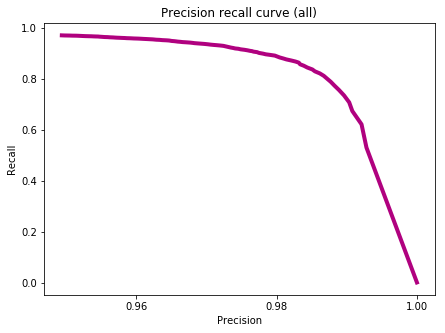

In [49]:
def plot_pr_curve(precision, recall, title):
    plt.rcParams['figure.figsize'] = 7, 5
    plt.locator_params(axis = 'x', nbins = 5)
    plt.plot(precision, recall, 'b-', linewidth=4.0, color = '#B0017F')
    plt.title(title)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.rcParams.update({'font.size': 16})
    
plot_pr_curve(precisions, recalls, 'Precision recall curve (all)')

In [55]:
for i, pre in enumerate(precisions):
    if pre>=0.965:
        print(threshold_values[i])
        break

0.7070707070707071


In [59]:
n_false_negative(test_data['sentiment'],apply_threshold(prob_of_positive, 0.98))

8230

In [80]:
# We only care about baby's products
baby_reviews = test_data[test_data['name'].apply(lambda x: 'baby' in str(x).lower())]
baby_matrix = vectorizer.transform(baby_reviews['review_clean'])
baby_prob = model.predict_proba(baby_matrix)[:,1]

In [84]:
b_r = []
b_p = []
for threshold in threshold_values:
    y_pred = apply_threshold(baby_prob, threshold)
    b_r.append(recall(baby_reviews['sentiment'], y_pred))
    b_p.append(precision(baby_reviews['sentiment'], y_pred))
    
for i, pre in enumerate(b_p):
    if pre>=0.965:
        print(threshold_values[i])
        break

0.7323232323232324
